In [37]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [8]:
df = pd.read_csv('../../data/data_cleaned.csv')

In [9]:
X = df.drop(columns='functional')
y = df['functional']

In [10]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

In [11]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 22), (40070,), (13357, 22), (13357,), (5937, 22), (5937,))

In [43]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cross_val=True, cv=5):
    '''
    
    '''
    if cross_val == True:
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])

        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}')
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
    
        plot_confusion_matrix(estimator, X_te, y_te)
    
        print("Training Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}")

        print("<>"*10)
        print("Testing Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Pre-modeling transformations

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



In [14]:
#creating Pipelines for each column type: numeric, categorical with under 10 categories, categorical with over 10 categories
#We moved iterative imputer to numeric columns because it will only work on numerics

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer()),
    ('mm', MinMaxScaler())
    
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])




### Important Note About IterativeImputer text

This is straight up copied from : https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
So if we use any of the below we need to rewrite and cite

In [19]:
#This works!
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

In [34]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=5))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Average accuracy: 0.7284502121287746        +/- 0.003933611073398366
Average precision: 0.708478154543054        +/- 0.003588671165890485
Average recall: 0.8497517347738544        +/- 0.010523544089075361
Average f1 score: 0.7726697389062357        +/- 0.004197640382474238
Average roc_auc: 0.7932230357872366        +/- 0.008262167502537414


In [35]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=5))
])

evaluate(dt, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

Average accuracy: 0.7569004242575493        +/- 0.0033402343856459003
Average precision: 0.7772284804972205        +/- 0.0029958045602210405
Average recall: 0.7743978755354657        +/- 0.006319154356992929
Average f1 score: 0.7757959639653416        +/- 0.0036122299334117648
Average roc_auc: 0.7552476618944342        +/- 0.0032062926450818464


In [38]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=5))
])

evaluate(rf, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

Average accuracy: 0.8130771150486649        +/- 0.0036686648695082235
Average precision: 0.8099472160281366        +/- 0.005415740673274335
Average recall: 0.8570114022952392        +/- 0.005072842431654899
Average f1 score: 0.83279271558281        +/- 0.003019336827775486
Average roc_auc: 0.8918135975468038        +/- 0.002431646491144121


Training Scores:
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0
<><><><><><><><><><>
Testing Scores:
Test accuracy: 0.8176237179007262
Test precision: 0.8161919831223629
Test recall: 0.8559181415929203
Test f1 score: 0.8355831533477321
Test roc_auc: 0.8141631524291133


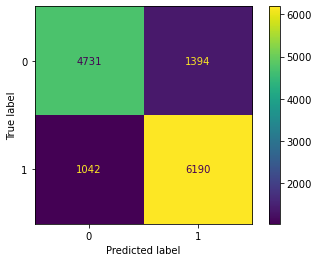

In [44]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=5))
])
evaluate(rf, X_train, X_test, y_train, y_test, cross_val=False, cv=5)

In [ ]:
test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
test_list = [{'name':'knn', 'type': KNeighborsClassifier(), 'params':{'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}},
            {'name': 'lr', 'type': LogisticRegression(), 'params':{'lr__fit_intercept':[False], 'lr__C':[1, 1000, 1e12],
                                                                  'lr__solver':['liblinear','newton-cg', 'lbfgs']}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        scores.append(gs_pipe.cv_results_)
    return scores